**Chapter 7 – Ensemble Learning and Random Forests**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/machinelearning/blob/main/070-ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# INTRODUCTION

- It can be proven that if you aggregate (e.g. by taken the average prediction) the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor.
- A group of predictors is called an _ensemble_.
- This technique is called _Ensemble Learning_.
- An Ensemble Learning algorithm is called an _Ensemble method_.

Example: 
- Train a group of Decision Tree classifiers, each on a different random subset of the training set. 
- To make predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes. 
- Such an ensemble of Decision Trees is called a _Random Forest_.
- This is one of the most powerful Machine Learning algorithms available today.

## THE BIAS/VARIANCE TRADE-OFF
A model’s generalization error can be expressed as the sum of three very different errors:

_Bias_ 

This part of the generalization error is due to wrong assumptions,
such as assuming that the data is linear when it is actually quadratic.
A high-bias model is most likely to **underfit** the training data.

_Variance_ 

This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus **overfit** the training data.

_Irreducible error_ 

This part is due to the **noisiness of the data** itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data
sources, such as broken sensors, or detect and remove outliers).

# Voting Classifiers

Typicall you choose several predictors to take part in the ensemble:

![](img/ensemble_diverse_predictors.png)

**Hard voting**

In _hard voting_ we predict the class that gets the most votes:

![](img/ensemble_hard_vorting.png)

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble.

Let's use the moons dataset to illustrate this:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


There you have it! The voting classifier slightly outperforms all the individual classifiers.

**Soft voting**
- If all classifiers are able to estimate class probabilities (i.e., they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. 
- This is called `soft voting`. 
- It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

All you have to do is pass the parameter `voting=soft` to the `VotingClassifier`. 

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting
Using a diverse set of classifiers:
- use very different training algorithms (see above)
- to use the same training algorithm for every predictor and train them on different random subsets of the training set
- _bagging_: sampling _with replacement_: each training sample can appear multiple times when training a single predictor
- _pasting_: sampling _without replacement_

Conclusion: 

- both bagging and pasting allow training instances to be sampled several times across multiple predictors.
- only bagging allows training instances to be sampled several times for the same predictor.

![](img/bagging-pasting.png)

- Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors.
- Most frequent predictor (like hard voting) for classification and average for regression.
- Each individual predictor has a higher bias than if it were trained on the original training set. 
- Aggregation reduces both bias and variance.
- Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.
- Predictors can all be trained in parallel, via different CPU cores or even different servers --> bagging and pasting scale very well. 


## Bagging and Pasting in Scikit-Learn
Use `BaggingClassifier` class or `BaggingRegressor` class

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1,random_state=42)  # n_jobs: number of CPU cores used for training and prediction (-1 = all availablre)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

**NOTE**  
The `BaggingClassifier` automatically performs soft voting instead of hard voting if the base
classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case
with Decision Tree classifiers.

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


As compared to a single decison tree:

In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


## Out-of-Bag evaluation

- With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 
- By default a BaggingClassifier samples $m$ training instances with replacement (`bootstrap=True`), where $m$ is the size of the
training set. 
- This means that statistically only about 63% of the training instances are sampled on average for each predictor. 
- The remaining 37% of the training instances that are not sampled are called _out-of-bag_ (oob) instances. 
- Note that they are not the same 37% for all predictors.
- Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. 
- You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

Let's compare this with the accuracy on the test set:

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Close enough!

# Random Forests

Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting).

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown),   
plus all thehyperparameters of a `BaggingClassifier` to control the ensemble itself.

A Random Forest is equivalent to a bag of decision trees:

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0,bootstrap=True,random_state=42)

In [16]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [17]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

0.976

## Feature Importance
Yet another great quality of Random Forests is that they make it easy to **measure the relative importance of each feature**.

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [19]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

This figure shows the features (= pixel) importance for the MNIST dataset:  

![](img/mnist_pixel_importance.png)

# Boosting
- Boosting refers to any Ensemble method that can combine several weak learners into a strong learner. 
- The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 
- There are many boosting methods available, but by far the most popular are _AdaBoost_ (short for _Adaptive Boosting_) and _Gradient Boosting_. 
- Let’s start with AdaBoost.
## AdaBoost
- One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. 
- This results in new predictors focusing more and more on the hard cases.
- The algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set.
- The algorithm then increases the relative weight of misclassified training instances. 
- Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on;

![](img/adaboost.png)

- Scikit-Learn uses a multiclass version of AdaBoost called _SAMME_ (which stands for **Stagewise Additive Modeling using a Multiclass Exponential loss function**).
- If the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), Scikit-Learn can use a variant of SAMME called SAMME.R.
- The R stands for “Real”, which relies on class probabilities rather than predictions and generally performs better.
- The learning rate determines the weights of the misclassified instances. 

In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

## Gradient Boosting

- Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. 
- However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.

Let create a simple quadratic dataset:

In [21]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Now let's train a decision tree regressor on this dataset:

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [23]:
y2 = y - tree_reg1.predict(X)  # residual errors
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:

In [24]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [36]:
X_new = np.array([[0.8]])

In [37]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [38]:
y_pred

array([0.75026781])

**Code to generate Figure 7–9. In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions:**

In [39]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


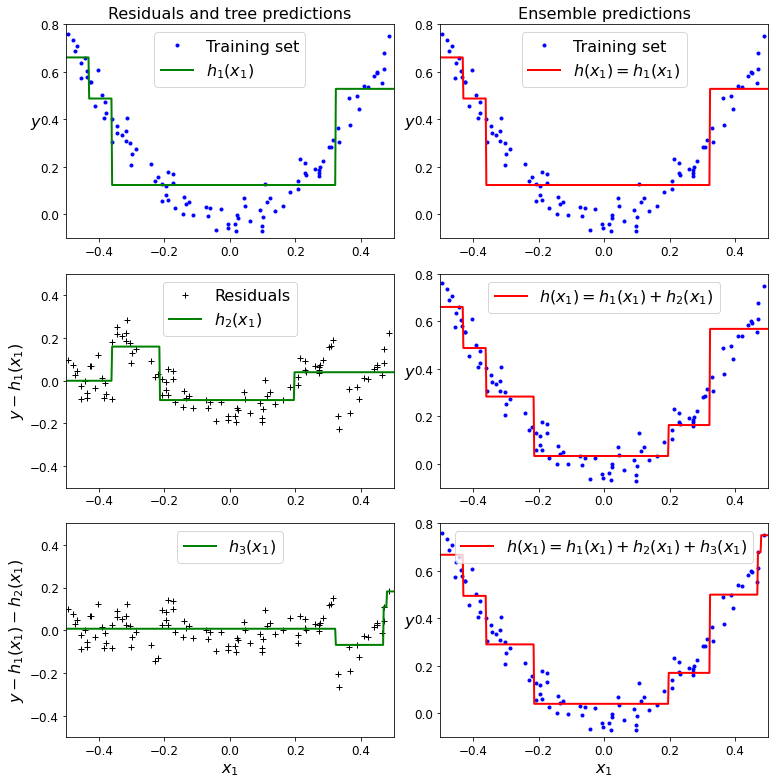

In [40]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Now let's try a gradient boosting regressor:

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**Code to generate Figure 7–10. GBRT ensembles with not enough predictors (left) and too many (right):**

In [42]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


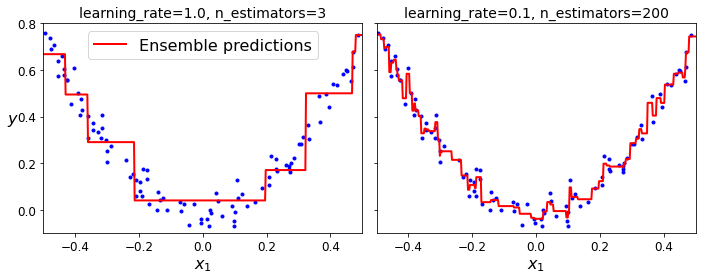

In [43]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**Gradient Boosting with Early stopping:**

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

**Code to generate Figure 7–11. Tuning the number of trees using early stopping:**

In [45]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


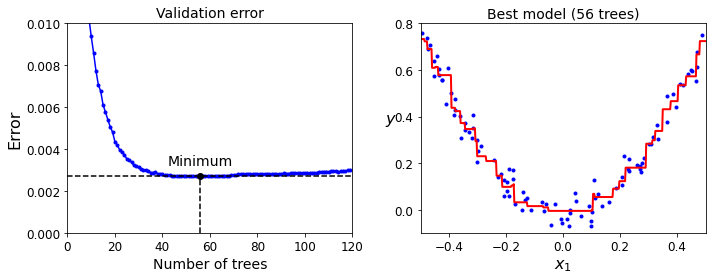

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

In [47]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [48]:
print(gbrt.n_estimators)

61


In [49]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**Using XGBoost:**

In [50]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [51]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.00400040950714611


In [52]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


In [53]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

76.1 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

20.8 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
